# Young's Modulus Machine Learning Models

In this notebook, we train and test 4 machine learning models to predict the Young's modulus from soil cavity simualtions.

| **Model**                                                          | **Description**                                                                                                                                                                                     |
|-------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Linear Regression with $H$, $d$, $M_w$, $M_c$                                         | Regularized multiple linear regression fitted with two numerical values: cavity depth $H$ and soil density $d$, orientations at the waist ($M_w$) and crown ($M_c$).|
| Linear Regression with $H$, $d$, $M_w$, $M_c$, $\sigma_r$                             | Regularized multiple linear regression fitted with vectorized stress fields $\sigma_r$ concatenated with $H$ and $d$, orientations at the waist ($M_w$) and crown ($M_c$).|
| Convolutional Neural Network with $H$, $d$, $M_w$, $M_c$, and $\sigma_r$              | Convolutional neural network with 6 hidden layers trained with cavity depth $H$, soil density $d$, orientations at the waist ($M_w$) and crown ($M_c$), and stress field images $\sigma_r$.   
| Mean-score Predictor                                                    | Predict $\phi$ using the average mean of $\phi$ scores in the training set.|

In [53]:
import numpy as np
import pandas as pd
import re
import cv2

from random import sample
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from glob import glob
from json import load, dump
from os.path import basename
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
from collections import Counter
from random import sample
from tqdm import tqdm

from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import copy
import scipy.io

RANDOM_SEED = 5012021

AttributeError: 'str' object has no attribute 'use'

## 0. Create the Dataset

In [18]:
input_df = pd.read_csv('./data/data-10-12/Disp_Output.csv')
input_df.head()

,Folder,Depth,d,E,v,phi,psi,c,sv,sh,Delft_inf,Delft_sug,Exists,yield_angle,yield_stress,yield_strain,ID,maxs,Mw,Mc
0,Disp_0,42,2108.58,49040300,0.292470,44.522842,14.1261,4999.998647,868.777132,259.596199,6113.901626,6089.417004,1,45.0,1371.814247,0.053224,1,3889.323653,3.424876e+07,1.716951e+07
1,Disp_1,42,2378.76,30544100,0.384267,30.984098,19.1708,4999.998860,980.096695,475.542763,4251.249310,4241.385338,1,NaN,inf,inf,2,7227.277284,2.259714e+07,6.655354e+06
2,Disp_10,26,1943.92,54098200,0.277512,31.420224,17.8703,4999.994369,495.816235,237.341833,3442.231579,3367.061231,1,NaN,inf,inf,3,5087.393552,4.221634e+07,1.950501e+07
3,Disp_100,37,2341.64,98842600,0.302208,36.306435,13.4055,4999.997057,849.945071,346.689454,6781.475357,6706.207493,1,NaN,inf,inf,4,4607.743639,7.228302e+07,3.485419e+07
4,Disp_1000,18,1794.09,51484900,0.339554,43.157792,14.0802,5000.006868,316.800412,100.105789,3325.922880,3142.177730,1,40.0,527.343236,0.022421,5,1593.593864,3.405497e+07,1.689281e+07


In [19]:
feature_df = input_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 14, 18, 19]]
feature_df.loc[:, 'phi'] = np.sin(feature_df['phi'])
feature_df.loc[:, 'psi'] = np.sin(feature_df['psi'])

# Need to handle the nan cases in the last feature
max_stress = list(np.sort(list(set(feature_df['yield_stress']))))[-2] * 1.2
feature_df.loc[:, 'yield_stress'] = [x if x != np.inf else max_stress for x in
                                     feature_df['yield_stress']]

/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [20]:
feature_df

,Folder,Depth,d,E,v,phi,psi,sv,sh,yield_stress,Mw,Mc
0,Disp_0,42,2108.58,49040300,0.292470,0.514604,0.999939,868.777132,259.596199,1371.814247,3.424876e+07,1.716951e+07
1,Disp_1,42,2378.76,30544100,0.384267,-0.418532,0.315747,980.096695,475.542763,12599.315984,2.259714e+07,6.655354e+06
2,Disp_10,26,1943.92,54098200,0.277512,0.004298,-0.830083,495.816235,237.341833,12599.315984,4.221634e+07,1.950501e+07
3,Disp_100,37,2341.64,98842600,0.302208,-0.984179,0.744062,849.945071,346.689454,12599.315984,7.228302e+07,3.485419e+07
4,Disp_1000,18,1794.09,51484900,0.339554,-0.734212,0.998378,316.800412,100.105789,527.343236,3.405497e+07,1.689281e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Disp_994,32,2229.42,40226900,0.357334,-0.965397,0.375137,699.859526,417.146417,12599.315984,3.009717e+07,4.791700e+06
1359,Disp_995,22,2193.27,32543800,0.303484,-0.817674,-0.482105,473.351531,288.790019,12599.315984,2.530108e+07,3.844875e+06
1360,Disp_996,23,1840.08,91644200,0.367731,0.991931,0.814962,415.177250,189.909436,1856.090156,6.426574e+07,3.248387e+07
1361,Disp_997,26,2175.94,47073400,0.380248,0.908312,-0.569548,554.995256,301.867349,12599.315984,3.444246e+07,9.688675e+06


In [21]:
feature_df_normalized = feature_df.copy()
feature_df_normalized

# feature_js = [1, 2, 3, 4, 7, 8]
feature_js = [1, 2, 4, 7, 8, 10, 11]
scaler = StandardScaler()
scaler.fit(feature_df.iloc[:, feature_js])
feature_df_normalized.iloc[:, feature_js] = scaler.transform(feature_df.iloc[:, feature_js])

In [22]:
feature_df_normalized

,Folder,Depth,d,E,v,phi,psi,sv,sh,yield_stress,Mw,Mc
0,Disp_0,1.096189,0.494497,49040300,-0.810510,0.514604,0.999939,1.229796,0.108418,1371.814247,-0.873115,-0.391815
1,Disp_1,1.096189,1.661630,30544100,1.336013,-0.418532,0.315747,1.630156,1.614973,12599.315984,-1.681844,-1.683193
2,Disp_10,-0.066483,-0.216807,54098200,-1.160278,0.004298,-0.830083,-0.111556,-0.046840,12599.315984,-0.320092,-0.104962
3,Disp_100,0.732854,1.501277,98842600,-0.582803,-0.984179,0.744062,1.162067,0.716026,12599.315984,1.766810,1.780266
4,Disp_1000,-0.647818,-0.864047,51484900,0.290473,-0.734212,0.998378,-0.755385,-1.004269,527.343236,-0.886566,-0.425800
...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Disp_994,0.369519,1.016506,40226900,0.706229,-0.965397,0.375137,0.622285,1.207570,12599.315984,-1.161273,-1.912092
1359,Disp_995,-0.357150,0.860344,32543800,-0.552965,-0.817674,-0.482105,-0.192350,0.312089,12599.315984,-1.494165,-2.028383
1360,Disp_996,-0.284483,-0.665378,91644200,0.949346,0.991931,0.814962,-0.401573,-0.377753,1856.090156,1.210337,1.489137
1361,Disp_997,-0.066483,0.785481,47073400,1.242035,0.908312,-0.569548,0.101281,0.403323,12599.315984,-0.859671,-1.310632


In [23]:
# Normalize E using the min and max values
e_range = np.max(feature_df['E']) - np.min(feature_df['E'])
e_min = np.min(feature_df['E'])
feature_df_normalized['norm_E'] = (feature_df_normalized['E'] - np.min(feature_df['E'])) / e_range

In [24]:
heatmap_image_data = np.load('./data/displayment-heatmaps-normalized-resized.npz')
heatmaps_images = heatmap_image_data['rs_normalized_heatmaps']
heatmaps_ids = heatmap_image_data['heatmaps_ids']

In [25]:
heatmaps_images.shape

(1363, 256, 256)

In [26]:
indexes = [int(x[5:]) for x in feature_df['Folder']]
indexes.index(10)

2

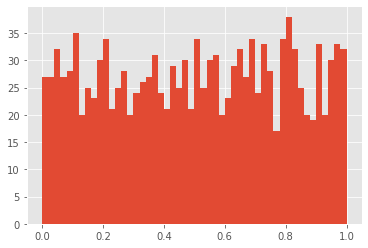

In [27]:
plt.hist(feature_df_normalized['norm_E'], bins=50)
plt.show()

In [28]:
features = []
scores = []

for i in tqdm(range(len(heatmaps_ids))):
    df_i = indexes.index(heatmaps_ids[i])
    
    # Collect the features
    row = feature_df_normalized.iloc[df_i, :]
    cur_features = row[['Depth', 'd', 'Mw', 'Mc']].to_numpy().astype(float)
    features.append((heatmaps_images[i], cur_features))
    
    # Collect the y's
    scores.append(row['norm_E'])

features = np.array(features)
scores = np.array(scores)

100%|██████████| 1363/1363 [00:00<00:00, 1730.33it/s]
/tmp/ipykernel_39665/2091989803.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


In [29]:
train_features, temp_features, train_scores, temp_scores = train_test_split(
    features, scores, train_size=0.6, random_state=RANDOM_SEED)
vali_features, test_features, vali_scores, test_scores = train_test_split(
    temp_features, temp_scores, train_size=0.5, random_state=RANDOM_SEED)

print(train_features.shape, train_scores.shape,
      vali_features.shape, vali_scores.shape,
      test_features.shape, test_scores.shape)

(817, 2) (817,) (273, 2) (273,) (273, 2) (273,)


## 1. Linear regression with Depth + Density + Mw + Mc

In [19]:
train_features_linear = []
vali_features_linear = []
test_features_linear = []

for i in tqdm(range(train_features.shape[0])):    
    train_features_linear.append(train_features[i][1].reshape(-1))
    
for i in tqdm(range(vali_features.shape[0])):
    vali_features_linear.append(vali_features[i][1].reshape(-1))
    
for i in tqdm(range(test_features.shape[0])):
    test_features_linear.append(test_features[i][1].reshape(-1))
    
train_features_linear = np.vstack(train_features_linear)
vali_features_linear = np.vstack(vali_features_linear)
test_features_linear = np.vstack(test_features_linear)

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 495905.15it/s]


In [20]:
train_features_linear.shape

(817, 4)

In [30]:
# Grid search the regularization power over validation set (Lasso regression)

# model = linear_model.Lasso()
# params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
# clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
# clf.fit(naive_train_features, train_scores)

# print(clf.cv_results_)
# print(clf.best_params_)
# print(clf.best_score_)

In [21]:
model = linear_model.Lasso(alpha=0.0001)
model.fit(train_features_linear, train_scores)

Lasso(alpha=0.0001)

In [22]:
def eval_model_sklearn(model, x, y, title=''):
    y_predict = model.predict(x)
    
    mse = metrics.mean_squared_error(y, y_predict)
    mae = metrics.mean_absolute_error(y, y_predict)
    
    mape = metrics.mean_absolute_percentage_error(
        [e_min + e_range * i for i in y],
        [e_min + e_range * i for i in y_predict]
    )
    
    print('{}\tMSE: {:.4f}  MAE: {:.4f}  MAPE: {:.4f}'.format(title, mse, mae, mape))
    
    return mse, mae

In [23]:
eval_model_sklearn(model, train_features_linear, train_scores, 'train')
eval_model_sklearn(model, vali_features_linear, vali_scores, 'vali')
eval_model_sklearn(model, test_features_linear, test_scores, 'test')

train	MSE: 0.0025  MAE: 0.0391  MAPE: 0.0425
vali	MSE: 0.0028  MAE: 0.0421  MAPE: 0.0432
test	MSE: 0.0025  MAE: 0.0387  MAPE: 0.0418


(0.0025044161928919092, 0.038707832583415744)

## 2. Linear Model with Depth + Density + Mw + Mc + Simulation Output

In [24]:
train_features_linear = []
vali_features_linear = []
test_features_linear = []

for i in tqdm(range(train_features.shape[0])):
    cur_feature = train_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, train_features[i][1].reshape(-1)])
    
    train_features_linear.append(cur_feature)
    
for i in tqdm(range(vali_features.shape[0])):
    cur_feature = vali_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, vali_features[i][1].reshape(-1)])
    
    vali_features_linear.append(cur_feature)
    
for i in tqdm(range(test_features.shape[0])):
    cur_feature = test_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, test_features[i][1].reshape(-1)])
    
    test_features_linear.append(cur_feature)
    
train_features_linear = np.vstack(train_features_linear)
vali_features_linear = np.vstack(vali_features_linear)
test_features_linear = np.vstack(test_features_linear)

100%|███████████████████████████████████████| 273/273 [00:00<00:00, 3433.47it/s]


In [25]:
train_features_linear.shape

(817, 65540)

In [26]:
train_scores.shape

(817,)

In [27]:
# Normalize the features

scaler = StandardScaler()
scaler.fit(train_features_linear)

train_features_linear_standardized = scaler.transform(train_features_linear)
vali_features_linear_standardized = scaler.transform(vali_features_linear)
test_features_linear_standardized = scaler.transform(test_features_linear)

In [31]:
# Grid search the regularization power over validation set (Lasso regression)

# model = linear_model.Lasso()
# params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
# clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
# clf.fit(naive_train_features, train_scores)

# print(clf.cv_results_)
# print(clf.best_params_)
# print(clf.best_score_)

In [28]:
model = linear_model.Lasso(alpha=0.0001, max_iter=10000)
model.fit(train_features_linear_standardized, train_scores)

/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021352178320096282, tolerance: 0.006940413142613379
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001, max_iter=10000)

In [32]:
def eval_model_sklearn(model, x, y, title=''):
    y_predict = model.predict(x)
    
    mse = metrics.mean_squared_error(y, y_predict)
    mae = metrics.mean_absolute_error(y, y_predict)
    
    mape = metrics.mean_absolute_percentage_error(
        [e_min + e_range * i for i in y],
        [e_min + e_range * i for i in y_predict]
    )
    
    print('{}\tMSE: {:.4f}  MAE: {:.4f}  MAPE: {:.4f}'.format(title, mse, mae, mape))
    
    return mse, mae

In [33]:
eval_model_sklearn(model, train_features_linear_standardized, train_scores, 'train')
eval_model_sklearn(model, vali_features_linear_standardized, vali_scores, 'vali')
eval_model_sklearn(model, test_features_linear_standardized, test_scores, 'test')

train	MSE: 0.0008  MAE: 0.0219  MAPE: 0.0246
vali	MSE: 0.0009  MAE: 0.0238  MAPE: 0.0257
test	MSE: 0.0009  MAE: 0.0230  MAPE: 0.0268


(0.0008995232953816017, 0.0230433916054929)

## 3. CNN Model with Depth + Density + Mw + Mc + Simulation Output

### 3.1 Model Training

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self, additional_feature_size):
        super(SimpleCNN, self).__init__()
        self.additional_feature_size = additional_feature_size
        self.conv1 = nn.Conv2d(1, 6, 3)     
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.pool1= nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(6, 6, 3)
        self.conv4 = nn.Conv2d(6, 6, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(6, 6, 3)
        self.conv6 = nn.Conv2d(6, 6, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(6 * 28 * 28 + self.additional_feature_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, image, feature):
        image = image.view(-1, 1, 256, 256)
        
        # Passing the CNN layers
        x = F.relu(self.conv1(image))
        x = self.pool1(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        
        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))
                
        x = x.view(-1, 6 * 28 * 28)
        
        # Concatenate with extra features
        x = torch.cat((x, feature), dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # x = F.softmax(x, dim=1)
        return x



In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# device = torch.device('cpu')

model = SimpleCNN(0)
image = torch.tensor([features[0][0]]).float().to(device)
feature = torch.tensor([features[0][1]]).float().to(device)[:, []]
model = model.to(device)
model(image, feature)

/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.0845]], device='cuda:0', grad_fn=<AddmmBackward>)

In [33]:
class HeatmapDataset(Dataset):

    def __init__(self, features, labels, std=0):
        self.features = features
        self.labels = labels
        self.std = std

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        cur_feature = self.features[idx]
        # label = nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=3)
        label = torch.tensor([self.labels[idx]]).float()
        
        # Load image and extra feature
        image = torch.tensor(cur_feature[0]).float()
        extra_feature = torch.tensor(cur_feature[1]).float()
        
        # Transform image
        image = image.view((1, 256, 256))

        # Add random noise
        noise = torch.normal(0, self.std, (1, 256, 256))
        image = torch.clamp(image + noise, 0, 1)
        
        sample = {'image': image, 'feature': extra_feature, 'label': label}

        return sample

In [12]:
def train_one_epoch(train_dataloader, epoch, print_every_ter=None, verbose=True,
                   selected_indexes=None):
    losses = []
    all_losses = []
    y_predict = []
    y_true = []
    for i, data in enumerate(train_dataloader, 0):
        cur_images, cur_features, cur_labels = (data['image'].to(device),
                                                data['feature'].to(device),
                                                data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(cur_images, cur_features)
        loss = criterion(outputs, cur_labels)
        loss.backward()
        optimizer.step()
        
        y_predict.extend(outputs.tolist())
        y_true.extend(cur_labels.tolist())

        # print statistics
        losses.append(loss.item())
        
        if print_every_ter != None:
            if i % print_every_ter == print_every_ter - 1:
                print('(epoch {}, iter {}) avg loss: {:3f}'.format(epoch + 1,
                                                                   i + 1,
                                                                   np.mean(losses)))
                all_losses.extend(losses)
                losses = []
        else:
            all_losses.append(loss.item())
    
    # Evaluate the accuracy
    mse = metrics.mean_squared_error(y_true, y_predict)
    avg_loss = np.mean(all_losses)
    
    if verbose:
        print('Epoch {}: training acc: {:.4f} avg loss: {:.4f}'.format(epoch, acc, avg_loss))

    return mse, avg_loss

In [13]:
def eval_model(test_dataloader, model, selected_indexes=None, l1_error=False):
    losses = []
    y_predict = []
    y_true = []

    for i, data in enumerate(test_dataloader, 0):
        cur_images, cur_features, cur_labels = (data['image'].to(device),
                                                data['feature'].to(device),
                                                data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # forward + backward + optimize
        outputs = model(cur_images, cur_features)
        loss = criterion(outputs, cur_labels)
        losses.append(loss.item())

        y_predict.extend(outputs.tolist())
        y_true.extend(cur_labels.tolist())
    
    mse = metrics.mean_squared_error(y_true, y_predict)
    mae = metrics.mean_absolute_error(y_true, y_predict)
    avg_loss = np.mean(losses)
    
    #print('Test accuracy {:.4f} test avg loss {:.4f}'.format(acc, avg_loss))
    
    if not l1_error:
        return mse, avg_loss
    else:
        return mae, avg_loss

In [47]:
std = 0.1
train_dataset = HeatmapDataset(train_features, train_scores, std=std)
vali_dataset = HeatmapDataset(vali_features, vali_scores, std=std)
test_dataset = HeatmapDataset(test_features, test_scores, std=std)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [48]:
#PATIENCE = 200
PATIENCE = 50
epochs = 2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)

selected_indexes = [0, 1, 2, 3]

model = SimpleCNN(len(selected_indexes)).to(device)

criterion = nn.MSELoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = []
train_avg_losses = []

val_mses = []
val_avg_losses = []

best_loss = np.inf
best_mse = np.inf
waited = 0
best_model = None

for e in tqdm(range(epochs)):
    mse, avg_loss = train_one_epoch(train_dataloader, e, verbose=False,
                                    selected_indexes=selected_indexes)
    train_mses.append(mse)
    train_avg_losses.append(avg_loss)
    
    # Test on the validation set
    val_mse, val_avg_loss = eval_model(vali_dataloader, model,
                                       selected_indexes=selected_indexes)
    val_mses.append(val_mse)
    val_avg_losses.append(val_avg_loss)
    
    if val_mse < best_mse:
        # best_loss = val_avg_loss
        best_mse = val_mse
        waited = 0
        best_model = copy.deepcopy(model)
    else:
        waited += 1
    
    if waited == PATIENCE + 1:
        break

print('Done!')
torch.save(best_model.state_dict(), './model/cnn-e-extra.model')

Using device: cuda


 22%|██▏       | 430/2000 [10:57<39:59,  1.53s/it]

Done!


### 3.2 Model Evaluation

Since we have normalzied the E, the performance is not very easy to interpret. Here we transform the predicted E to their original scale, and then compute performance metrics.

In [34]:
device = torch.device('cuda')
print('Using device:', device)

criterion = nn.MSELoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
selected_indexes = [0, 1, 2, 3]

model = SimpleCNN(len(selected_indexes)).to(device)
model.load_state_dict(torch.load('./model/cnn-e-extra.model'))

Using device: cuda


<All keys matched successfully>

In [35]:
def eval_model_transformed(test_dataloader, model, selected_indexes=None):
    losses = []
    y_predict = []
    y_true = []

    for i, data in enumerate(test_dataloader, 0):
        cur_images, cur_features, cur_labels = (data['image'].to(device),
                                                data['feature'].to(device),
                                                data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # forward + backward + optimize
        outputs = model(cur_images, cur_features)
        loss = criterion(outputs, cur_labels)
        losses.append(loss.item())
        
        outputs = outputs.cpu().detach().numpy().reshape(-1).tolist()
        cur_labels = cur_labels.cpu().detach().numpy().reshape(-1).tolist()
#         break

#         outputs = [scaler.mean_[2] + i * scaler.scale_[2] for i in outputs]
#         cur_labels = [scaler.mean_[2] + i * scaler.scale_[2] for i in cur_labels]

        outputs = [e_range * i + e_min for i in outputs]
        cur_labels = [e_range * i + e_min for i in cur_labels]

        y_predict.extend(outputs)
        y_true.extend(cur_labels)
        
#     print(np.array(y_predict) - np.array(y_true))
    
    mse = metrics.mean_squared_error(y_true, y_predict)
    mae = metrics.mean_absolute_error(y_true, y_predict)
    mape = metrics.mean_absolute_percentage_error(y_true, y_predict)
    avg_loss = np.mean(losses)
    
    #print('Test accuracy {:.4f} test avg loss {:.4f}'.format(acc, avg_loss))
    
#     return mae, avg_loss, y_predict, y_true
    return mape, mae, avg_loss

Compute the MAPE, MAE, average loss

In [56]:
result = {
    'std': [],
    'train': [],
    'vali': [],
    'test': [],
}

for std in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:

    device = torch.device('cuda')
    print('Using device:', device)

    criterion = nn.MSELoss()
    lr = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    selected_indexes = [0, 1, 2, 3]

    model = SimpleCNN(len(selected_indexes)).to(device)
    model.load_state_dict(torch.load(f'./model/cnn-e-extra-noise-{std}.model'))

    train_dataset = HeatmapDataset(train_features, train_scores, std=std)
    vali_dataset = HeatmapDataset(vali_features, vali_scores, std=std)
    test_dataset = HeatmapDataset(test_features, test_scores, std=std)

    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    vali_dataloader = DataLoader(vali_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)


    r_train = eval_model_transformed(train_dataloader, model, selected_indexes=selected_indexes)
    r_vali = eval_model_transformed(vali_dataloader, model, selected_indexes=selected_indexes)
    r_test = eval_model_transformed(test_dataloader, model, selected_indexes=selected_indexes)

    result['std'].append(std)
    result['train'].append(r_train[0])
    result['vali'].append(r_vali[0])
    result['test'].append(r_test[0])


Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda


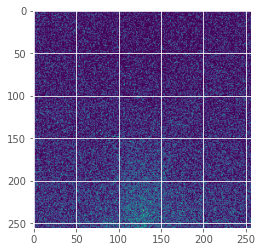

In [55]:
std = 0.1

train_dataset = HeatmapDataset(train_features, train_scores, std=std)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

for img in train_dataloader:
    plt.imshow(img['image'][0, 0])
    plt.show()
    break

In [57]:
result_df = pd.DataFrame(result)
result_df

,std,train,vali,test
0,0.1,0.018879,0.020407,0.020717
1,0.2,0.020267,0.021801,0.023326
2,0.3,0.019050,0.020379,0.020926
3,0.4,0.021632,0.023423,0.023087
4,0.5,0.019577,0.021348,0.021251
5,0.6,0.020948,0.021711,0.022273
6,0.7,0.020987,0.021887,0.023050
7,0.8,0.020576,0.021810,0.023102
8,0.9,0.021121,0.022746,0.022799
9,1.0,0.021964,0.022519,0.022578


## 4. Naive Baseline Model

Finally, we can "train" a naive baseline model that uses the average values in the training set for all predictions.

In [55]:
train_features_linear = []
vali_features_linear = []
test_features_linear = []

for i in tqdm(range(train_features.shape[0])):    
    train_features_linear.append(train_features[i][1].reshape(-1))
    
for i in tqdm(range(vali_features.shape[0])):
    vali_features_linear.append(vali_features[i][1].reshape(-1))
    
for i in tqdm(range(test_features.shape[0])):
    test_features_linear.append(test_features[i][1].reshape(-1))
    
train_features_linear = np.vstack(train_features_linear)
vali_features_linear = np.vstack(vali_features_linear)
test_features_linear = np.vstack(test_features_linear)

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 351672.29it/s]


In [56]:
train_score_orginal = np.array([e_min + e_range * i for i in train_scores])
vali_score_orginal = np.array([e_min + e_range * i for i in vali_scores])
test_score_orginal = np.array([e_min + e_range * i for i in test_scores])

In [57]:
metrics.mean_absolute_percentage_error(train_score_orginal, np.ones(train_score_orginal.shape) * np.mean(train_score_orginal))

0.3249746499370797

In [58]:
metrics.mean_absolute_percentage_error(vali_score_orginal, np.ones(vali_score_orginal.shape) * np.mean(train_score_orginal))

0.29321693808323723

In [59]:
metrics.mean_absolute_percentage_error(test_score_orginal, np.ones(test_score_orginal.shape) * np.mean(train_score_orginal))

0.32342642057320686